In [26]:
import matplotlib.pyplot as plt
import sys
import time
import scipy.io as io
import os
from os import listdir
import glob
import time

import cv2
import numpy as np
from opt_flow import draw_flow



import math
from skimage import data
from skimage import filters
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import binary_closing, binary_opening, binary_dilation, disk,remove_small_objects,label
from skimage.color import label2rgb
from skimage.morphology import remove_small_holes, binary_erosion
from skimage.segmentation.boundaries import find_boundaries
from skimage.segmentation import clear_border
from skimage.measure import EllipseModel
from skimage.draw import ellipse
from skimage.filters import threshold_otsu, threshold_local
from scipy import ndimage as ndi
from skimage.measure import label, regionprops
from skimage import transform as tf
from scipy.signal import find_peaks
from skimage import filters
from skimage.filters import gaussian
import csv

from skimage import exposure
from skimage.morphology import reconstruction

from skimage.feature import peak_local_max
from scipy import ndimage as ndi

from skimage.segmentation import watershed


        
def MotionVectorCalculation(videoName, outputFolder, fps):
    cap = cv2.VideoCapture(videoName)
    (dirName,videoFileName) = os.path.split(videoName)

    outputPath = outputFolder+'\\' + videoFileName[:-4]
    if not os.path.isdir(outputPath):
        print('The directory is not present. Creating a new one..')
        os.mkdir(outputPath)
    else:
        print('The directory is present.')
    
    videoOut = outputPath+'\\' + videoFileName[:-4] + '_opticalFlow.avi'

    ret, frame1 = cap.read()
    prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255
    videoLen = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    print(videoOut)

    hei, wid = prvs.shape
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    VideoOutput = cv2.VideoWriter(videoOut, fourcc, fps, (2*wid,hei))

    magStack = np.zeros([hei, wid, int(videoLen)-1],dtype =  np.float64)
    angStack = np.zeros([hei, wid, int(videoLen)-1],dtype =  np.float64)

    for ii in range(int(videoLen)-1):
        ret, frame2 = cap.read()
        next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prvs,next, None, .5, 3, 15, 3, 5, 1.2, 0)

        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        #hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        hsv[...,2] = mag*50
        #print(np.max(mag))
        bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        vis = draw_flow(next, flow*16)

        magStack[:,:,ii] = mag
        angStack[:,:,ii] = ang
        #bgr = np.concatenate((frame2,bgr),axis=1)
        #bgr = np.concatenate((bgr,vis),axis=1)

        #cv2.imshow('frame2',bgr)
        #k = cv2.waitKey(30) & 0xff
        #if k == 27:
        #    break
        #elif k == ord('s'):
        #    cv2.imwrite('opticalfb.png',frame2)
        #    cv2.imwrite('opticalhsv.png',bgr)

        if ii%50==0:
            print(ii)

        prvs = next

        frame_final = np.concatenate((bgr,vis),axis=1)
        VideoOutput.write(frame_final)

    VideoOutput.release()    
    cap.release()
    cv2.destroyAllWindows()
    
    return magStack, angStack

def CellSegmentation(img_enhance,block_size=25,offset=0.02):
    img_gray=img_enhance[:,:,0]
    
    local_thresh = threshold_local(img_gray, block_size, offset=0.02)
    binary_local = img_gray < local_thresh
  
    cellMask1 = binary_closing(binary_local,disk(1))
    cellMask2 = ndi.binary_fill_holes(cellMask1)
    
    cellMask3 =  remove_small_objects(cellMask2,50)

    cellMask4 = binary_closing(cellMask3,disk(2))
    cellMask5 = ndi.binary_fill_holes(cellMask4)
    cellMask6 = binary_erosion(cellMask5,disk(1))
    cellMask7 = binary_opening(cellMask6,disk(3))

    cellMask8 =  remove_small_objects(cellMask7,200)
    
    cellMask9 = binary_opening(cellMask8,disk(3))

    distance = ndi.distance_transform_edt(cellMask9)
    coords = peak_local_max(distance, min_distance=3,footprint=np.ones((3, 3)), labels=cellMask9)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=cellMask8)
    seg = labels>0
    seg = binary_opening(seg,disk(5))
    
    return seg

def movingCellDetection(subfolder,fps=100.0,interFrame=1):
    print(subfolder)    
    # Downsampling in resolution
    ds_res = 1
    # Downsampling in time
    ds_time = interFrame 
##for subfolder in subfolders[0:len(subfolders):1]:
##for subfolder in subfolders[49:72]:
    imageNameRoot =  subfolder  + "\\tiff\\*.tif"
    #B9, C2,C4
    (dirName,videoFileName) = os.path.split(subfolder)

    imageNameRoot0 = dirName
    videoName = videoFileName
    # Output video frame rate (needs to check the true image acqusition frequency and the ds_time defined below)
        
    videoOut = subfolder+'\\' + videoName + '_video_ds.avi'

    imageNames = sorted(glob.glob(imageNameRoot))
    imageNum = len(imageNames)
    
    if imageNum>1500:
        fps=200.0
    img0 = cv2.imread(imageNames[0])
    img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    img = img1[::ds_res,::ds_res]

    hei, wid = img.shape

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    VideoOutput = cv2.VideoWriter(videoOut, fourcc, fps, (wid,hei))


    mm = 0
    tic = time.time()

    for jj in range(0,imageNum-1,interFrame):
        img0 = cv2.imread(imageNames[jj])
        img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
        img = img1[::ds_res,::ds_res]
         
        frame_final = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) 

        #frame_final=np.concatenate((frame_final,vis),axis=1) 

        VideoOutput.write(frame_final)
        mm+=1
        if mm%100==0:
            print(mm)
    toc = time.time()
    print(toc-tic)     

    VideoOutput.release()
    cv2.destroyAllWindows()
    toc = time.time()

In [236]:
rootDir = r'E:\Troponin_programs\Troponin_data\Plate2'

outputFolder = rootDir

if not os.path.isdir(outputFolder):
    print('The OUTPUT directory is not present. Creating a new one..')
    os.mkdir(outputFolder)
        
subfolders = [os.path.join(rootDir, o) for o in os.listdir(rootDir) if os.path.isdir(os.path.join(rootDir,o))]
subfolders = sorted(subfolders)
print(subfolders)


['E:\\Troponin_programs\\Troponin_data\\Plate2\\Plate2_NoMatrigel_s02', 'E:\\Troponin_programs\\Troponin_data\\Plate2\\Plate2_NoMatrigel_s12', 'E:\\Troponin_programs\\Troponin_data\\Plate2\\Plate2_NoMatrigel_s49']


In [237]:
###for subfolder in subfolders:
subfolder=subfolders[2]
print(subfolder)
interFrame=10
ds_time = interFrame 

imageNameRoot =  subfolder  + "\\tiff\\*.tif"
    #B9, C2,C4
(dirName,videoFileName) = os.path.split(subfolder)

imageNameRoot0 = dirName
imageNames = sorted(glob.glob(imageNameRoot))
imageNum = len(imageNames)
print(dirName)
print(imageNames[0])
print(imageNum)
fps=100.0
if imageNum>1500:
    fps=200.0
    

E:\Troponin_programs\Troponin_data\Plate2\Plate2_NoMatrigel_s49
E:\Troponin_programs\Troponin_data\Plate2
E:\Troponin_programs\Troponin_data\Plate2\Plate2_NoMatrigel_s49\tiff\frame_0001.tif
1940


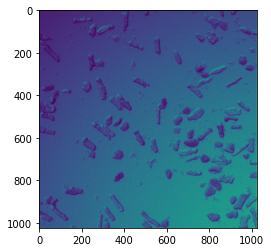

In [238]:
kk = 0
stackLen = len(imageNames)//ds_time
img0 = cv2.imread(imageNames[0])
img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
reg_hei,reg_wid = img1.shape
imgStack = np.zeros([reg_hei, reg_wid, int(stackLen)+1],dtype =  np.float32)

for ii in range(0,imageNum,ds_time):
    img0 = cv2.imread(imageNames[ii])
    img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    imgStack[:,:,kk]=img1
    kk = kk+1

imgStack.astype(np.float32)
plt.imshow(imgStack[:,:,0])

In [239]:
from scipy.fftpack import fftn,fftfreq

# sample spacing
T = 1.0 / stackLen*ds_time

# Number of sample points
N = stackLen
print(imgStack.shape)
print(T)
print(stackLen)

xf = fftfreq(N, T)[:N//2]

freq_range = np.where((np.array(xf)>0.5) & (np.array(xf)<1.5)) ##only check freqency domain from 0.5hz to 1.5hz

print(freq_range[0])
print(type(freq_range))
print(imgStack.dtype)
print(imgStack.shape)
imgStackFFT =np.abs(fftn(imgStack, axes=2))
print(imgStackFFT.shape)
imgFFTMax= np.max(imgStackFFT[:,:,freq_range[0]],axis=2)
print(imgStackFFT.shape)
print(imgFFTMax.shape)

(1024, 1024, 195)
0.05154639175257732
194
[ 6  7  8  9 10 11 12 13 14]
<class 'tuple'>
float32
(1024, 1024, 195)
(1024, 1024, 195)
(1024, 1024, 195)
(1024, 1024)


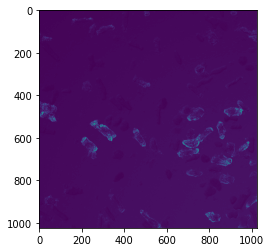

In [240]:
plt.imshow(imgFFTMax)

7.8475633
4.472699
4.488724
0.41951182
5.007347583770752
2559.4905
87.592865
100.35917
86.077515
149.50765991210938


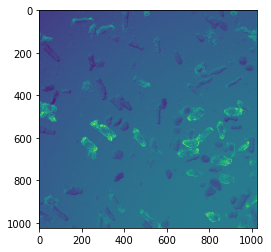

In [241]:
plt.imshow(np.log(imgFFTMax+1))

print(np.max(np.log(imgFFTMax)))
print(np.median(np.log(imgFFTMax)))
print(np.mean(np.log(imgFFTMax)))
print(np.std(np.log(imgFFTMax)))
print(np.percentile(np.log(imgFFTMax[:]),95))

print(np.max(imgFFTMax))
print(np.median(imgFFTMax))
print(np.mean(imgFFTMax))
print(np.std(imgFFTMax))
print(np.percentile(imgFFTMax[:],95))

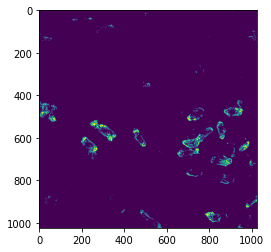

In [242]:
th = np.mean(imgFFTMax)+3*np.std(imgFFTMax)
th_log=np.mean(np.log(imgFFTMax))+3*np.std(np.log(imgFFTMax))
plt.imshow(imgFFTMax>th)

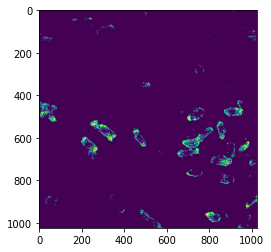

In [243]:
plt.imshow(np.log(imgFFTMax)>th_log)

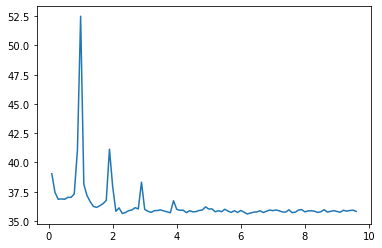

In [244]:
plt.plot(xf[1:N//2],np.mean(np.mean(imgStackFFT[120:250,0:50,1:N//2],axis=0),axis=0))

(array([ 6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=int64),)
<class 'tuple'>


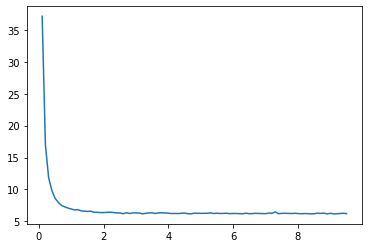

In [217]:
plt.plot(xf[1:N//2],np.mean(np.mean(imgStackFFT[350:450,950:1010,1:N//2],axis=0),axis=0))
print(freq_range)
print(type(freq_range))

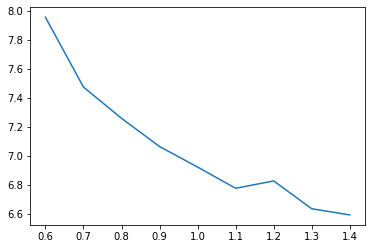

In [218]:
plt.plot(xf[freq_range[0]],np.mean(np.mean(imgStackFFT[350:450,950:1010,freq_range[0]],axis=0),axis=0))

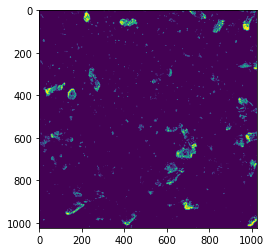

In [139]:
plt.imshow(np.log(imgFFTMax)>th_log)

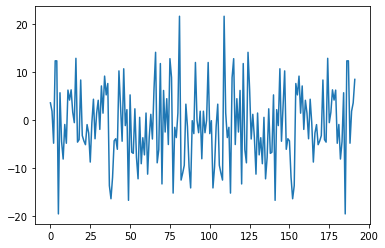

In [94]:
plt.plot(imgStackFFT[50,50,2:])

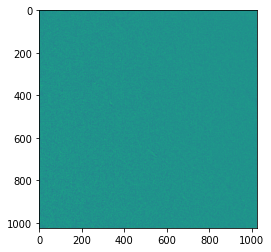

In [85]:
plt.imshow(np.real(imgStackFFT[:,:,100]))

In [319]:
movingCellDetection(subfolder,fps=100.0,interFrame=1):
    print(subfolder)    
    # Downsampling in resolution
    ds_res = 1
    # Downsampling in time
    ds_time = interFrame 
##for subfolder in subfolders[0:len(subfolders):1]:
##for subfolder in subfolders[49:72]:
    imageNameRoot =  subfolder  + "\\tiff\\*.tif"
    #B9, C2,C4
    (dirName,videoFileName) = os.path.split(subfolder)

    imageNameRoot0 = dirName
    videoName = videoFileName
    # Output video frame rate (needs to check the true image acqusition frequency and the ds_time defined below)
        
    videoOut = subfolder+'\\' + videoName + '_video_ds.avi'

    imageNames = sorted(glob.glob(imageNameRoot))
    imageNum = len(imageNames)
    
    if imageNum>1500:
        fps=200.0
    img0 = cv2.imread(imageNames[0])
    img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    img = img1[::ds_res,::ds_res]

    hei, wid = img.shape

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    VideoOutput = cv2.VideoWriter(videoOut, fourcc, fps, (wid,hei))


    mm = 0
    tic = time.time()

    for jj in range(0,imageNum-1,interFrame):
        img0 = cv2.imread(imageNames[jj])
        img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
        img = img1[::ds_res,::ds_res]
         
        frame_final = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) 

        #frame_final=np.concatenate((frame_final,vis),axis=1) 

        VideoOutput.write(frame_final)
        mm+=1
        if mm%100==0:
            print(mm)
    toc = time.time()
    print(toc-tic)     

Z:\TROPONIN2021\20210511DataSetAnalysisDebug\subDataSet\Plate1\Plate1_Matrigel_s01\Plate1_Matrigel_s01_video_ds.avi
The directory is present.
Z:\TROPONIN2021\20210511DataSetAnalysisDebug\subDataSetOutput\\Plate1_Matrigel_s01_video_ds\Plate1_Matrigel_s01_video_ds_opticalFlow.avi
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900


In [321]:
img_annotated = cv2.imread('.\\subDataSetOutput\\Plate1_Matrigel_s01_video_ds\\Plate1_Matrigel_s01_frame_0001_annotated.tif')
img_raw = cv2.imread('.\\subDataSetOutput\\Plate1_Matrigel_s01_video_ds\\Plate1_Matrigel_s01_frame_0001.tif')
mag_mean = cv2.imread('.\\subDataSetOutput\\Plate1_Matrigel_s01_video_ds\\Plate1_Matrigel_s01_video_ds_mean_activity.tif')
mag_max = cv2.imread('.\\subDataSetOutput\\Plate1_Matrigel_s01_video_ds\\Plate1_Matrigel_s01_video_ds_max_activity.tif')
img_enhance = exposure.equalize_adapthist(img_raw,kernel_size=25)
print(img_annotated.shape)
print(img_raw.shape)
print(mag_mean.shape)

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


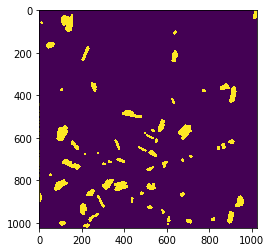

In [322]:
binary_local=CellSegmentation(img_enhance,block_size=19,offset=0.2)
plt.imshow(binary_local)

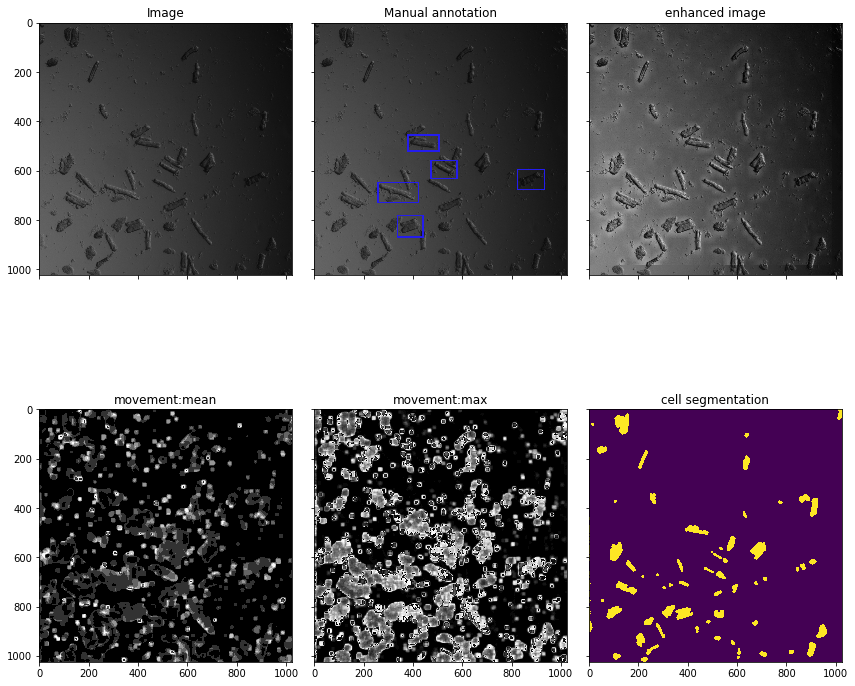

In [323]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 12))
ax[0][0].imshow(img_raw)
ax[0][0].set_title('Image')
ax[0][1].imshow(img_annotated)
ax[0][1].set_title('Manual annotation')
ax[0][2].imshow(img_enhance)
ax[0][2].set_title('enhanced image')
ax[1][0].imshow(mag_mean*50)
ax[1][0].set_title('movement:mean')
ax[1][1].imshow(mag_max*10)
ax[1][1].set_title('movement:max')
ax[1][2].imshow(binary_local)
ax[1][2].set_title('cell segmentation')
fig.tight_layout()

plt.show()

In [324]:
print(np.max(mag_mean[:,:,0]))
print(np.median(mag_mean[:,:,0]))
print(np.min(mag_mean[:,:,0]))
print(np.mean(mag_mean[:,:,0]))
print(np.std(mag_mean[:,:,0]))


10
0.0
0
0.5294151306152344
0.9732603936213887


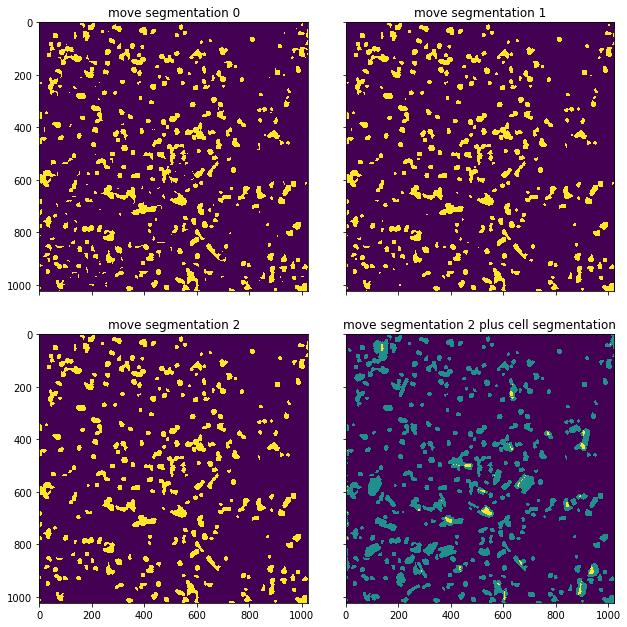

In [325]:
movement_local0=mag_mean[:,:,0]>np.mean(mag_mean[:,:,0])+np.std(mag_mean[:,:,0])*1.0
movement_local1 = binary_opening(movement_local0,disk(3))
movement_local2 = remove_small_objects(movement_local1,100)

move_cell = (movement_local2>0).astype(int)+(binary_local>0).astype(int)
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 9))
ax[0][0].imshow(movement_local0)
ax[0][0].set_title('move segmentation 0')
ax[0][1].imshow(movement_local1)
ax[0][1].set_title('move segmentation 1')
ax[1][0].imshow(movement_local2)
ax[1][0].set_title('move segmentation 2')
ax[1][1].imshow(move_cell)
ax[1][1].set_title('move segmentation 2 plus cell segmentation')
fig.tight_layout()

plt.show()

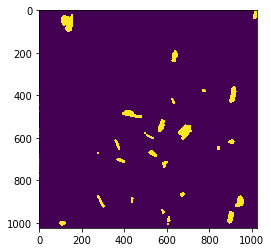

In [326]:
cells = reconstruction((movement_local2>0).astype(int),move_cell)
seg = np.logical_and(binary_local>0,cells>0)
plt.imshow(seg)

1


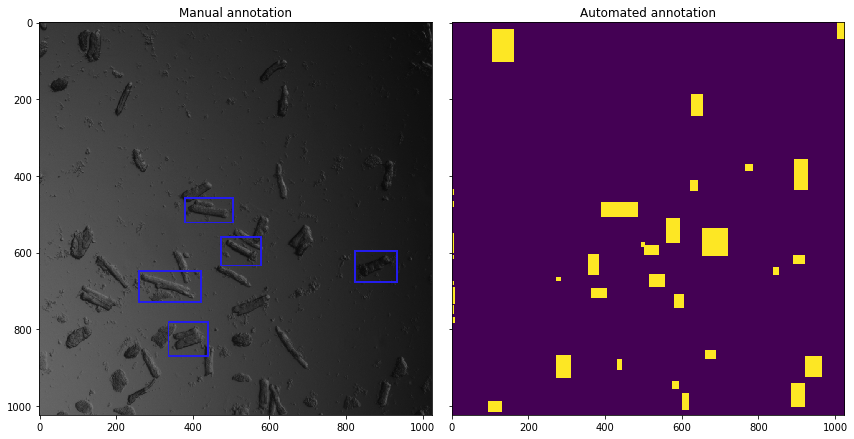

In [327]:
seg_label=label(seg)
seg_box = seg.astype(int)
print(np.max(seg_box))
props = regionprops(seg_label)
for ii in range(len(props)):
###for ii in range(1):
    seg_box[props[ii].bbox[0]:props[ii].bbox[2],props[ii].bbox[1]:props[ii].bbox[3]] = 1


fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 12))
ax[0].imshow(img_annotated)
ax[0].set_title('Manual annotation')
ax[1].imshow(seg_box)
ax[1].set_title('Automated annotation')
fig.tight_layout()

plt.show()